In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
column_names = [
    "GaiaEDR3", "RAdeg", "e_RAdeg", "DEdeg", "e_DEdeg", "Plx", "e_Plx",
    "pmRA", "e_pmRA", "pmDE", "e_pmDE", "Gmag", "RFG", "BPmag",
    "RFBP", "RPmag", "RFRP", "E(BP/RP)", "RUWE", "IPDfmp",
    "RV", "e_RV", "r_RV", "f_RV", "GCNSprob", "WDprob",
    "Dist1", "Dist16", "Dist50", "Dist84", "xcoord50", "xcoord16", "xcoord84",
    "ycoord50", "ycoord16", "ycoord84", "zcoord50", "zcoord16", "zcoord84",
    "Uvel50", "Uvel16", "Uvel84", "Vvel50", "Vvel16", "Vvel84",
    "Wvel50", "Wvel16", "Wvel84", "GUNN", "r_GUNN",
    "gmag", "e_gmag", "rmag", "e_rmag", "imag", "e_imag", "zmag", "e_zmag",
    "2MASS", "Jmag", "e_Jmag", "Hmag", "e_Hmag", "Ksmag", "e_Ksmag",
    "WISE", "W1mag", "e_W1mag", "W2mag", "e_W2mag",
    "W3mag", "e_W3mag", "W4mag", "e_W4mag"
]

x = pd.read_csv("table1c.csv", header = None)
x.columns = column_names

In [3]:
oumuamua = np.array([-11.457, -22.395, -7.746]) # Mamajek (2017)
# heliocentric Galactic velocity

LSR = np.array([-10, -11, -7]) # Mamajek (2017)
# consensus LSR estimate from Bland-Hawthorn & Gerhard (2016)

oumuamua_LSR_velocity = np.sqrt(np.sum(oumuamua-LSR)**2)
print(oumuamua_LSR_velocity)

13.598


In [4]:
# get the median U, V, W of the GCNS sample
U_median = np.median(x["Uvel50"].dropna())
V_median = np.median(x["Vvel50"].dropna())
W_median = np.median(x["Wvel50"].dropna())
# expect U, W to be around LSR
# expect V to lag due to asymmetric drift
print(np.round([U_median, V_median, W_median], 3))

[-10.785 -17.858  -7.442]


In [5]:
# get the standard deviations in U, V, W of the GCNS sample
U_std = np.std(x["Uvel50"].dropna())
V_std = np.std(x["Vvel50"].dropna())
W_std = np.std(x["Wvel50"].dropna())

print(np.round([U_std, V_std, W_std], 3))
np.sqrt(U_std**2 + V_std**2 + W_std**2)

[37.519 28.821 21.78 ]


52.083869351386284

In [6]:
# issue: not many GCNS stars have velocities
# example below...
print(x.iloc[0][["GaiaEDR3", "Uvel50"]])
print(x[x["Dist50"] < 0.020]["Uvel50"].isna().sum())

GaiaEDR3    2334666126716440064
Uvel50                      NaN
Name: 0, dtype: object
1029


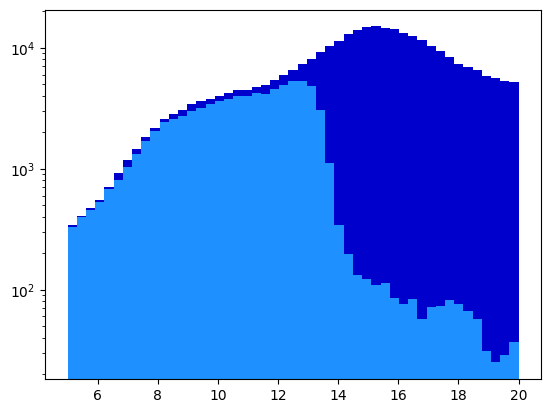

In [63]:
# radial velocities seem to be magnitude-limited
fig, ax = plt.subplots()
df_with_vel = np.array(x[x[['Uvel50', 'Vvel50', 'Wvel50']].notnull().all(axis=1)][["Gmag"]]).flatten()
df_without_vel = np.array(x[~x[['Uvel50', 'Vvel50', 'Wvel50']].notnull().all(axis=1)][["Gmag"]]).flatten()


ax.hist([df_with_vel, df_without_vel], stacked="True",\
    bins = np.linspace(5, 20),\
    label = ["with velocities", "without velocities"],\
    color = ["dodgerblue", "mediumblue"])
#ax.hist(df_without_vel["Gmag"], stacked = True)
ax.set_yscale("log")

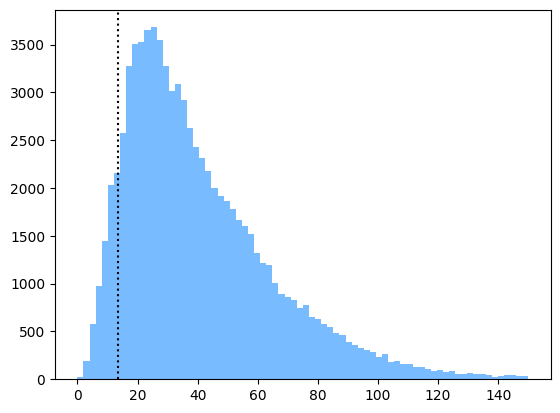

In [7]:
# get the LSR velocities of the stars
fig, ax = plt.subplots()
to_plot = np.sqrt(((x["Uvel50"] - LSR[0])**2\
    + (x["Vvel50"]- LSR[1])**2 \
    + (x["Wvel50"] - LSR[2])**2)).dropna()

ax.hist(to_plot, bins = np.linspace(0, 150, 75), color = "dodgerblue", alpha = 0.6)
ax.axvline(oumuamua_LSR_velocity, c = "black", ls = ":")

plt.show()

In [8]:
# for what fraction of stars with velocities is
#   `Oumuamua's velocity versus the LSR slower?
(to_plot > oumuamua_LSR_velocity).sum()/len(to_plot)

0.9179436120352606

In [9]:
# number density of stars within 100pc
n_stars = len(x[x["Dist50"] < 0.1])
stars_per_pc_cubed = n_stars / (4/3 * np.pi * 100**3)
print(stars_per_pc_cubed)

0.07173431595037907


In [33]:
n_stars

300480

In [10]:
#U0, V0, W0 = [7.5, 13.5, 6.8] # solar peculiar motion

In [30]:
# get a dataframe of the velocities 
vel_cols = ['Uvel50', 'Vvel50', 'Wvel50']
df_velocities = x[x[vel_cols].notnull().all(axis=1)].copy()
df_velocities = df_velocities.reset_index(drop=True)

collisional_velocities = []

# select n_rows random rows within this dataframe
n_rows = 1000
sample_rows = df_velocities.sample(n_rows).index

for r in tqdm(sample_rows):
    tmp_df = df_velocities.sample(1000)
    for i, row in tmp_df.iterrows():
        if i == r:
            pass
        else:
            # select the rows from the dataframe
            row = df_velocities.iloc[r]
            row2 = df_velocities.iloc[i]
            # get the velocity difference between the stars
            vel_diff = np.sqrt((row["Uvel50"] - row2["Uvel50"])**2\
                + (row["Vvel50"] - row2["Vvel50"])**2\
                + (row["Wvel50"] - row2["Wvel50"])**2)
            # append that velocity to the running list of collisional velocities
            collisional_velocities.append(vel_diff)

100%|██████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.26it/s]


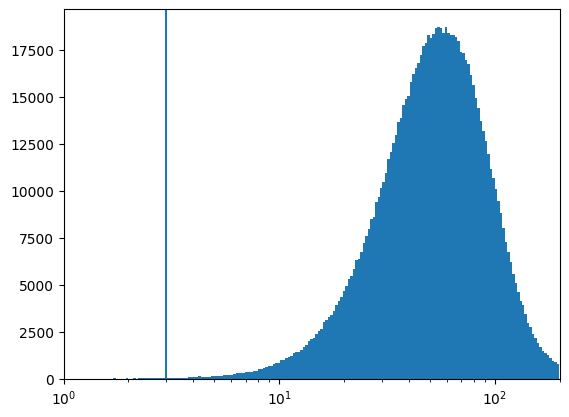

In [45]:
fig, ax = plt.subplots()
ax.hist(collisional_velocities, bins = np.logspace(0, 2.3, 200))
ax.axvline(3)
ax.set_xlim(1, 200)
ax.set_xscale("log")
plt.show()

In [36]:
(np.array(collisional_velocities) < 2).sum()/len(collisional_velocities)

0.00013800082800496802

In [ ]:
# Monte Carlo "disk-kick model"
"""
1. initialize host stars with kinematics like those of molecular clouds
2. simulate disk-heating for each one by generating Poisson-distributed
  events for each star in the population
3. at each event, draw from 3D Maxwell-Boltzmann distribution and apply
  the velocity kick to perturb the star
4. at a certain galactic time, look at the distribution of ISO velocities
    - how many particles have old ages and `Oumuamua-like kinematics
    - how many particles are young and have `Oumuamua-like kinematics
    - how do these results compare to kinematically-complete survey like LAMOST
"""
